In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager


# read humidity binned values over SST to prepare the composite plot
path_SST_binned = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/'
filename = 'arthus_binned_sst_4.nc'
arthus_data = xr.open_dataset(path_SST_binned+filename)
mr_data = arthus_data['MR'].values
sst_arr = arthus_data['sst'].values
height = arthus_data['height'].values


# calculating uncertainty propagation for wvmr
from myFunctions import f_uncertainty_prop #f_uncertainty_prop(data, sigma_o, n_days, n_sigma, varstring):
''' function to propagate the uncertainty in the measurement and calculate the non-significative bins)
    inputs:
    - data: xarray dataset of data to be plotted
    - sigma_o: initial uncertainty in the data to be provided 
    - n_days: number of days used for the computation of the diurnal cycle
    - n_sigma: number of sigma chosen to check whether the measurement is different than zero.
    - varstring: string identifying the variable name
    outputs: 
    - result : xarray with values smaller than n_sigma*sigma_shf_final masked ''' 
masked_mr = f_uncertainty_prop(arthus_data, 1., 8, 3, 'MR')



/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


In [2]:
# reading radiosonde binned data
radiosonde_data = xr.open_dataset(path_SST_binned+'RS_mean_profiles_binned_sst.nc')
MR_rs = radiosonde_data['MR'].values
binned_sst_rs = radiosonde_data['sst'].values
height_rs = radiosonde_data['height'].values


#defining color palette for subsequent plots
colors_binned_sst = plt.cm.seismic(np.linspace(0, 1, len(binned_sst_rs)))
# plot multipanel with all profiles


In [3]:
binned_sst_rs

array([26.3, 26.6, 26.8, 27.1, 27.3, 27.6])

['SST=26.3', 'SST=26.6', 'SST=26.8', 'SST=27.1', 'SST=27.3', 'SST=27.6']


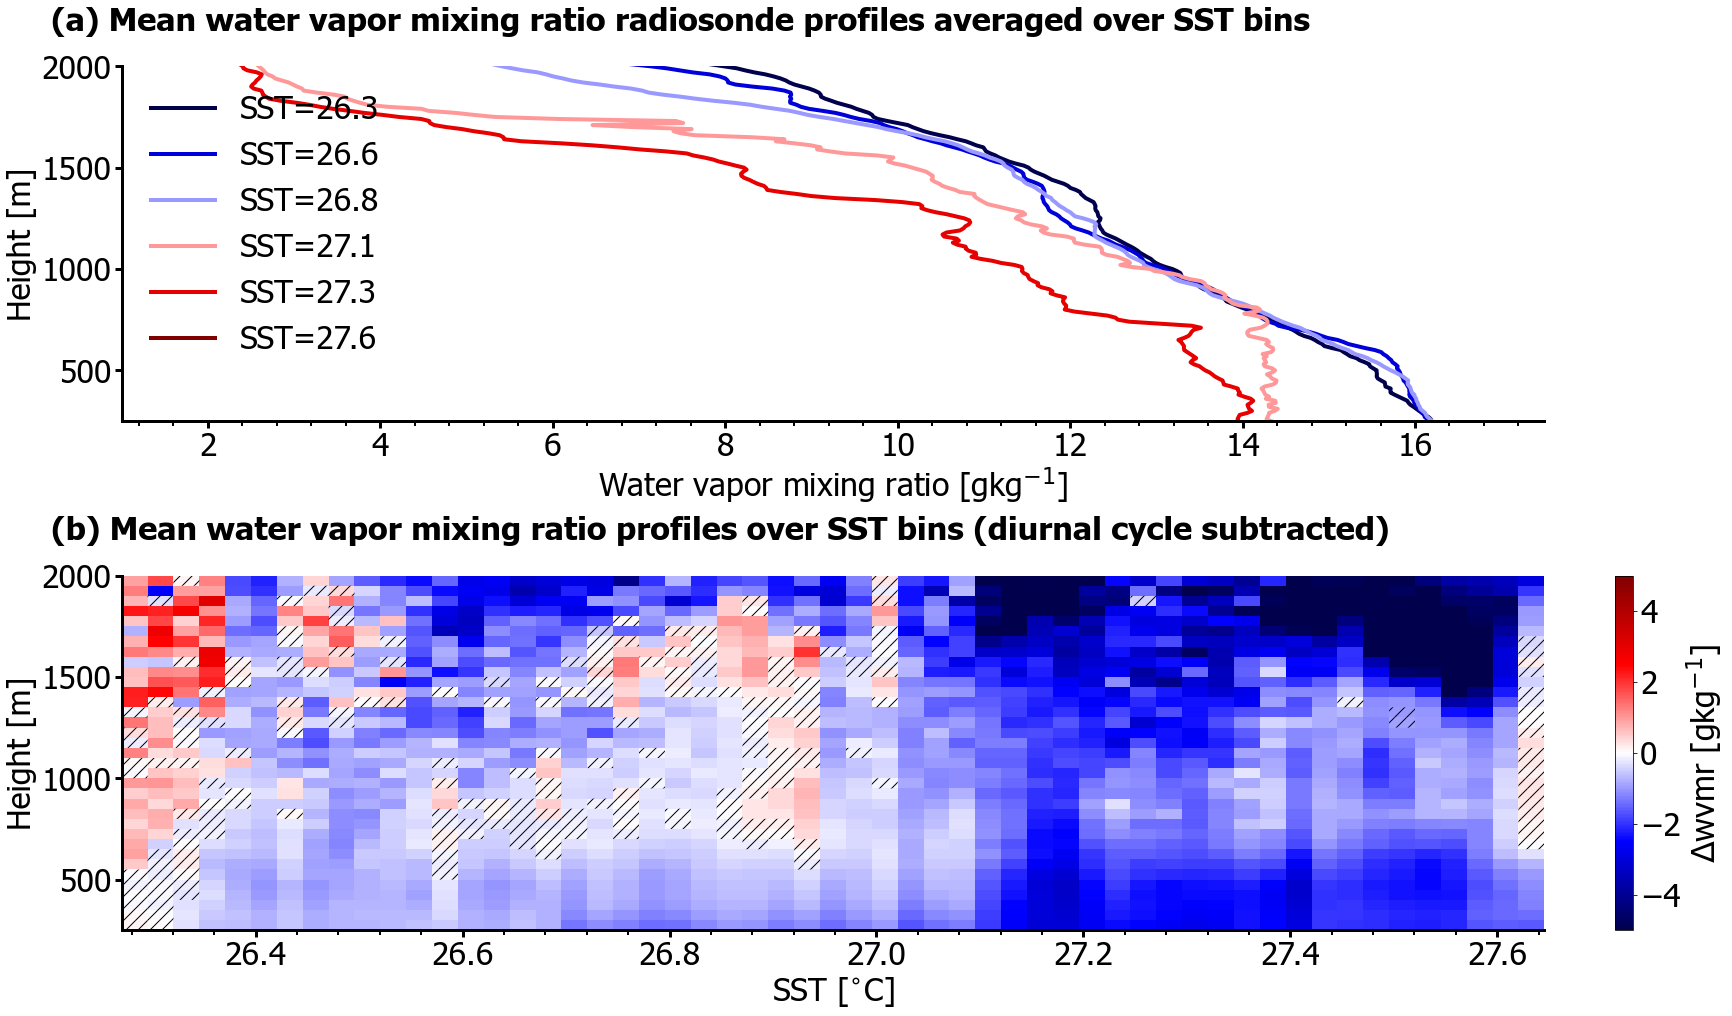

In [4]:

# calculate label marks for bins
sst_bin_label = []
for ind in range(len(binned_sst_rs)-1):
    sst_bin_label.append(round((binned_sst_rs[ind]+binned_sst_rs[ind+1])/2,2))
    


labels =[]
for ind, el in enumerate(binned_sst_rs):
    labels.append('SST='+str(el))
print(labels)
font = font_manager.FontProperties(family='Tahoma',
                                   weight='light',
                                   style='normal', size=12)


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'



dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :15,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(2,1, figsize=(24,14), constrained_layout=True)

# setting dates formatter 
#[a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) for a in axs[:].flatten()]
matplotlib.rc('xtick', labelsize=32)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=32)  # sets dimension of ticks in the plots
grid            = dict_plot_settings['grid']

for ind_sst_bin in range(len(binned_sst_rs)): 
    axs[0].plot(MR_rs[ind_sst_bin,:]*1000., height_rs, color=colors_binned_sst[ind_sst_bin], label=labels[ind_sst_bin], linewidth=4, rasterized=True)
axs[0].legend(frameon=False, fontsize=fontSizeX, loc='upper left')
axs[0].set_xlabel("Water vapor mixing ratio [gkg$^{-1}$]", fontsize=fontSizeX)
axs[0].set_ylabel("Height [m]", fontsize=fontSizeY)
axs[0].set_xlim(1,17.5)

mesh = axs[1].pcolormesh(sst_arr, height, mr_data.T, cmap='seismic', vmin=-5, vmax=5, )
axs[1].pcolor(sst_arr, height, masked_mr.T, hatch='//', alpha=0.)

cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label(label='$\Delta$wvmr [gkg$^{-1}$]',  size=fontSizeX)
axs[1].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

for ax, l in zip(axs[:].flatten(), ['(a) Mean water vapor mixing ratio radiosonde profiles averaged over SST bins  ',  '(b) Mean water vapor mixing ratio profiles over SST bins (diurnal cycle subtracted) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
    ax.set_ylim(250.,2000.)

fig.savefig(path_out_plots+'figure_wvmr.png', format='png')

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# reading files from Agostino with data from ERA 5 istantaneous and mean on warm/cold 
varname = 'q'; units='g_kg';xlabel = 'Water vapour mixing ratio [g/kg]'; xmin = 5; xmax = 16


# Space and time info.
lon_warm = -52.75; lat_warm = 8.25 # date_2 = '2020-02-02T00:00:00' on the R/V Atalante trajectory.
lon_cold = -54.4; lat_cold = 6.5 # date_3 = '2020-02-03T12:00:00' on the R/V Atalante trajectory.
dlon = 0.5; dlat = 0.5

date_2 = '2020-02-02T00:00:00'; date_2_str = '2Feb 00UTC'
date_3 = '2020-02-03T12:00:00'; date_3_str = '3Feb 06UTC'

date_start = '2020-02-02'
date_end = '2020-02-03'

# Figure 1
path_file2read = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/data_agostino/'
file2read = path_file2read+'warm_cold_instants_data_' + varname +'.txt'
ndf = pd.read_csv(file2read)

mean_w2 = ndf[varname+'_w2_'+units]
mean_c2 = ndf[varname+'_c2_'+units]
mean_w3 = ndf[varname+'_w3_'+units]
mean_c3 = ndf[varname+'_c3_'+units]
z_w2 = ndf['height_w2']
z_c2 = ndf['height_c2']
z_w3 = ndf['height_w3']
z_c3 = ndf['height_c3']


# Figure 2

file2read = path_file2read+'warm_cold_time_avg_data_' + varname +'.txt'
ndf = pd.read_csv(file2read)

mean_w = ndf['mean_'+varname+'_w_'+units]
std_w = ndf['std_'+varname+'_w_'+units]
mean_c = ndf['mean_'+varname+'_c_'+units]
std_c = ndf['std_'+varname+'_c_'+units]
z_w = ndf['height_w']
z_c = ndf['height_c']



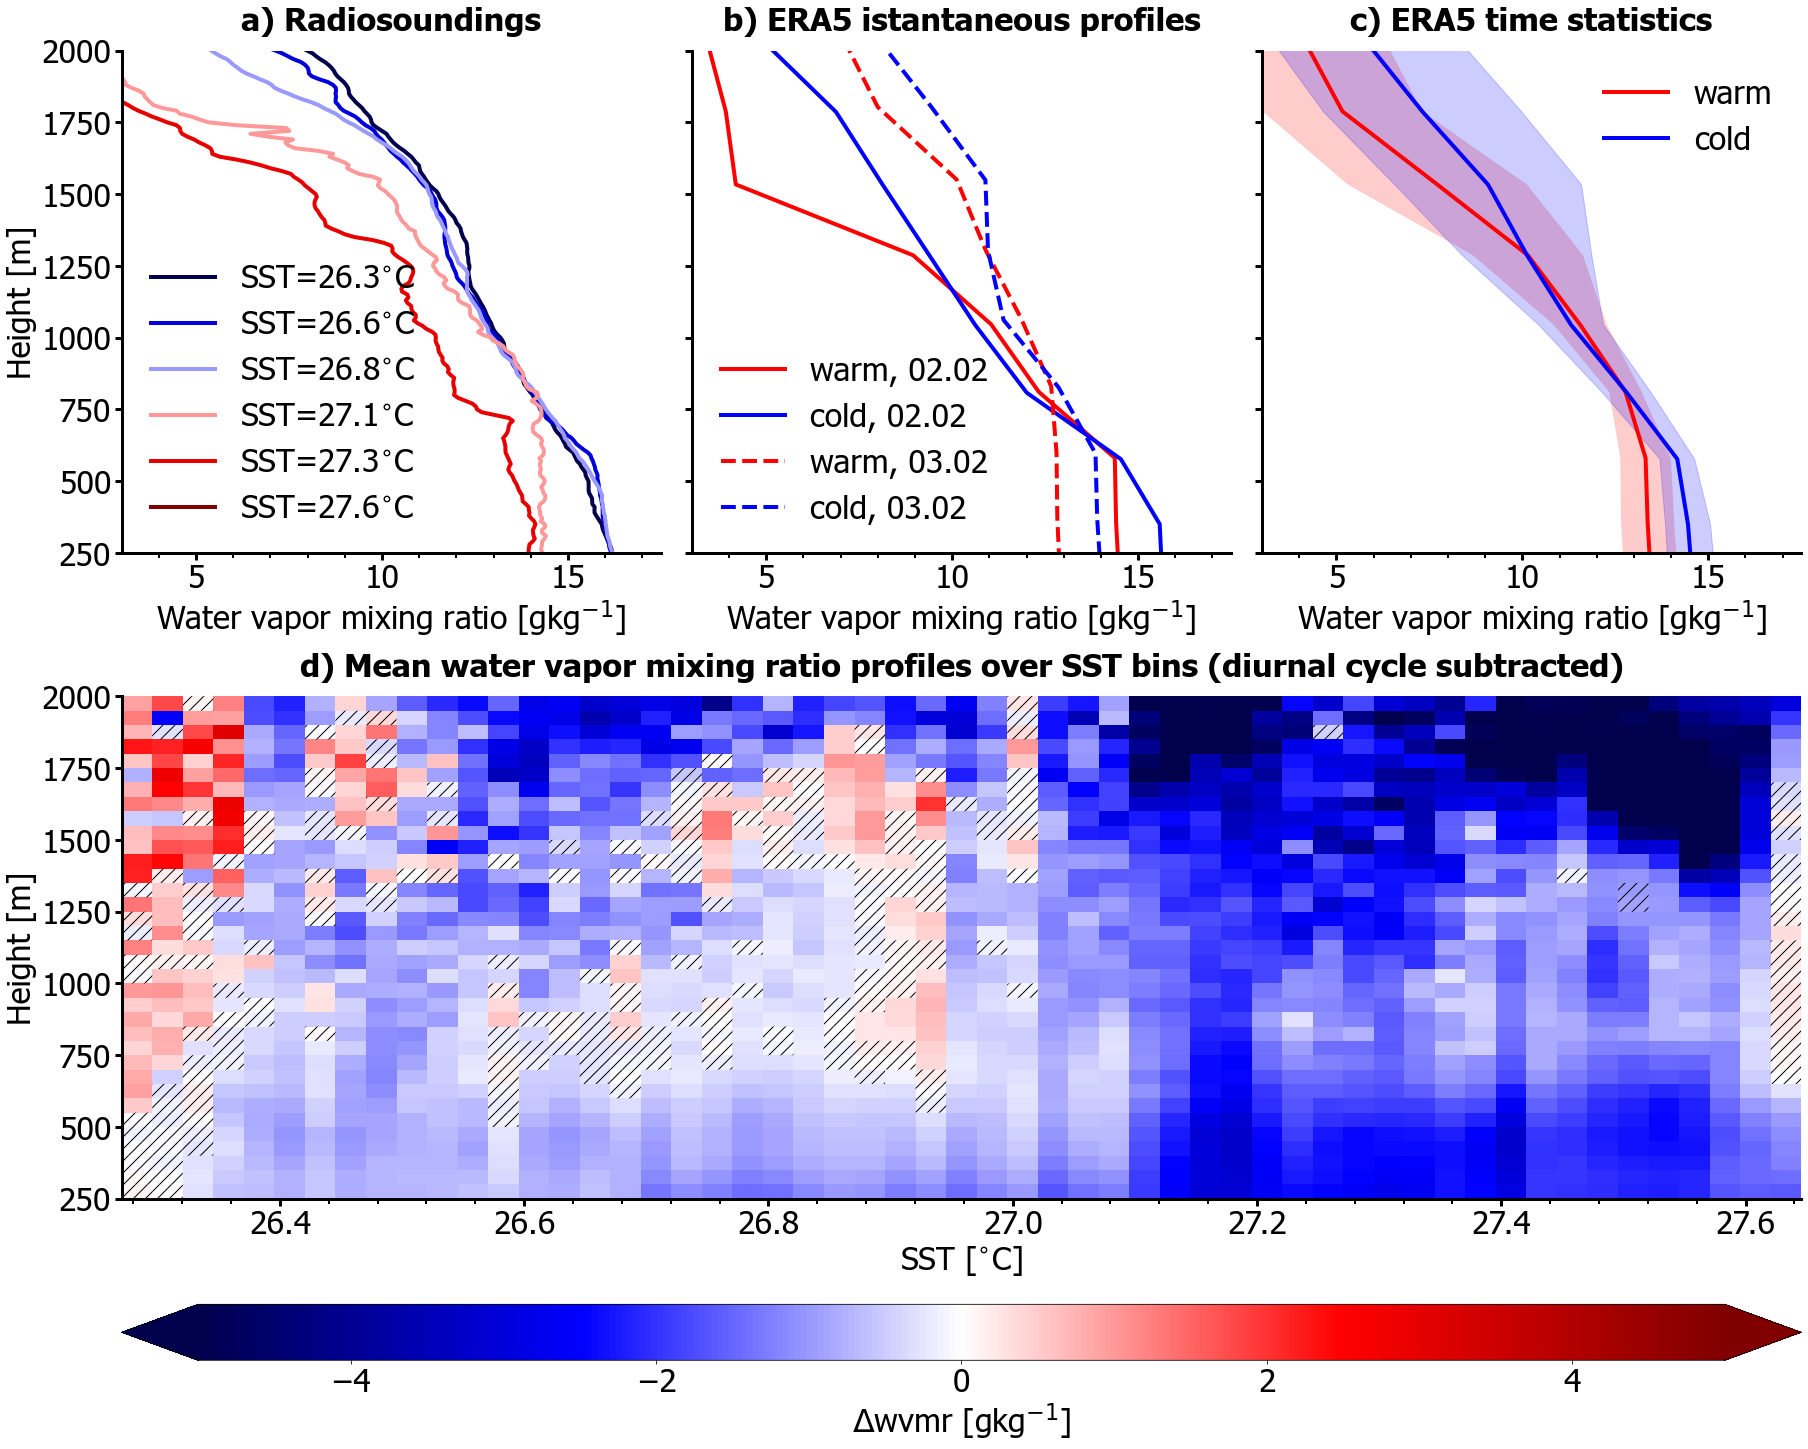

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
rcParams['axes.titlepad'] = 20 
#gs = gridspec.GridSpec(3, 3)
fig, axs = plt.subplots(2, 3, figsize=(25,20), sharey=True, constrained_layout=True)# 


#ax = fig.add_subplot(gs[0, 0])

for ind_sst_bin in range(len(binned_sst_rs)): 
    axs[0,0].plot(MR_rs[ind_sst_bin,:]*1000., height_rs, color=colors_binned_sst[ind_sst_bin], label=labels[ind_sst_bin]+'$^{\circ}$C', linewidth=4, rasterized=True)
axs[0,0].legend(frameon=False, fontsize=fontSizeX, loc='lower left')
axs[0,0].set_xlabel("Water vapor mixing ratio [gkg$^{-1}$]", fontsize=fontSizeX)
axs[0,0].set_ylabel("Height [m]", fontsize=fontSizeY)
axs[0,0].set_xlim(3,17.5)
axs[0,0].spines["top"].set_visible(False)
axs[0,0].spines["right"].set_visible(False)
axs[0,0].spines["bottom"].set_linewidth(3)
axs[0,0].spines["left"].set_linewidth(3)
axs[0,0].set_title('a) Radiosoundings', fontsize=32, fontweight='black')

axs[0,0].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,0].tick_params(which='minor', length=5, width=2)
axs[0,0].tick_params(which='major', length=7, width=3)
axs[0,0].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,0].tick_params(axis='both', labelsize=32)
axs[0,0].set_ylim(250.,2000.)    

#-----------------------------

axs[0,1].plot(mean_w2, z_w2, color='red', linewidth=4, rasterized=True, label='warm, 02.02')
axs[0,1].plot(mean_c2, z_c2, color='blue', linewidth=4, rasterized=True, label='cold, 02.02')
axs[0,1].plot(mean_w3,z_w3,'--', color='red', linewidth=4, rasterized=True, label='warm, 03.02')
axs[0,1].plot(mean_c3,z_c3,'--', color='blue', linewidth=4, rasterized=True, label='cold, 03.02')
axs[0,1].set_xlim(3,17.5)
axs[0,1].legend(frameon=False)

axs[0,1].spines["top"].set_visible(False)
axs[0,1].spines["right"].set_visible(False)
axs[0,1].spines["bottom"].set_linewidth(3)
axs[0,1].spines["left"].set_linewidth(3)
axs[0,1].set_title('b) ERA5 istantaneous profiles', fontsize=32, fontweight='black')
axs[0,1].set_xlabel("Water vapor mixing ratio [gkg$^{-1}$]", fontsize=fontSizeX)

axs[0,1].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,1].tick_params(which='minor', length=5, width=2)
axs[0,1].tick_params(which='major', length=7, width=3)
axs[0,1].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,1].tick_params(axis='both', labelsize=32)
axs[0,1].set_ylim(250.,2000.)

#-----------------------------

axs[0,2].plot(mean_w,z_w,'r', linewidth=4, rasterized=True, label='warm')
axs[0,2].plot(mean_c,z_c,color='blue', linewidth=4, rasterized=True, label='cold')
axs[0,2].fill(np.append(mean_w-std_w, np.flip(mean_w+std_w)),np.append(z_w, np.flip(z_w)),'r',alpha=0.2)
axs[0,2].fill(np.append(mean_c-std_c, np.flip(mean_c+std_c)),np.append(z_c, np.flip(z_c)),color='blue',alpha=0.2)
axs[0,2].set_xlim(3,17.5)
axs[0,2].legend(frameon=False)
axs[0,2].spines["top"].set_visible(False)
axs[0,2].spines["right"].set_visible(False)
axs[0,2].spines["bottom"].set_linewidth(3)
axs[0,2].spines["left"].set_linewidth(3)
axs[0,2].set_title('c) ERA5 time statistics', fontsize=32, fontweight='black')
axs[0,2].set_xlabel("Water vapor mixing ratio [gkg$^{-1}$]", fontsize=fontSizeX)

axs[0,2].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,2].tick_params(which='minor', length=5, width=2)
axs[0,2].tick_params(which='major', length=7, width=3)
axs[0,2].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axs[0,2].tick_params(axis='both', labelsize=32)
axs[0,2].set_ylim(250.,2000.)

#-----------------------------
gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])
axbig.spines["top"].set_visible(False)
axbig.spines["right"].set_visible(False)
axbig.spines["bottom"].set_linewidth(3)
axbig.spines["left"].set_linewidth(3)
axbig.set_title('d) Mean water vapor mixing ratio profiles over SST bins (diurnal cycle subtracted)', fontsize=32, fontweight='black')

axbig.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axbig.tick_params(which='minor', length=5, width=2)
axbig.tick_params(which='major', length=7, width=3)
axbig.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
axbig.tick_params(axis='both', labelsize=32)
axbig.set_ylim(250.,2000.)
mesh = axbig.pcolormesh(sst_arr, height, mr_data.T, cmap='seismic', vmin=-5, vmax=5)
axbig.pcolor(sst_arr, height, masked_mr.T, hatch='//', alpha=0.)
cbar = fig.colorbar(mesh, ax=axbig, orientation='horizontal', extend='both', aspect=30)
cbar.set_label(label='$\Delta$wvmr [gkg$^{-1}$]',  size=fontSizeX)
axbig.set_ylabel('Height [m]', fontsize=fontSizeX)
axbig.set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)

fig.savefig(path_out_plots+'figure_wvmr.png', format='png')

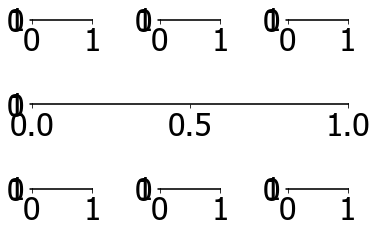

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=3)
gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])
#axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#               xycoords='axes fraction', va='center')

fig.tight_layout()

plt.show()